In [172]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import random
import torch
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer, models
#import plotly.io as pio
#pio.renderers.default='notebook'
pd.option_context('display.max_rows', None)

In [173]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\freSi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [174]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\freSi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [175]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\freSi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Exploratory data analysis

In [176]:
df = pd.read_excel("potential-talents.xlsx").set_index('id')
print(df)

                                             job_title  \
id                                                       
1    2019 C.T. Bauer College of Business Graduate (...   
2    Native English Teacher at EPIK (English Progra...   
3                Aspiring Human Resources Professional   
4               People Development Coordinator at Ryan   
5      Advisory Board Member at Celal Bayar University   
..                                                 ...   
100  Aspiring Human Resources Manager | Graduating ...   
101              Human Resources Generalist at Loparex   
102   Business Intelligence and Analytics at Travelers   
103                     Always set them up for Success   
104   Director Of Administration at Excellence Logging   

                                location connection  fit  
id                                                        
1                         Houston, Texas         85  NaN  
2                                 Kanada      500+   NaN  
3    Rale

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104 entries, 1 to 104
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   job_title   104 non-null    object 
 1   location    104 non-null    object 
 2   connection  104 non-null    object 
 3   fit         0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 4.1+ KB


In [178]:
df.replace('500+ ','500', inplace=True)

In [179]:
df['connection'] = pd.to_numeric(df['connection'])

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104 entries, 1 to 104
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   job_title   104 non-null    object 
 1   location    104 non-null    object 
 2   connection  104 non-null    int64  
 3   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.1+ KB


In [181]:
df['job_title'].value_counts()

job_title
2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional                 7
Aspiring Human Resources Professional                                                                                    7
Student at Humber College and Aspiring Human Resources Generalist                                                        7
People Development Coordinator at Ryan                                                                                   6
Native English Teacher at EPIK (English Program in Korea)                                                                5
Aspiring Human Resources Specialist                                                                                      5
HR Senior Specialist                                                                                                     5
Student at Chapman University                                                                                            4
SVP, C

### Data preprocessing and cleaning

Cleaning data: tokenization, remove stop words, normalise with lower case, eliminate extra spaces, lemmatization and eliminate acronymises.

In [182]:
stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)
lemmatizer = WordNetLemmatizer()
for ind, row in df.iterrows():
    words = [lemmatizer.lemmatize(word) for word in word_tokenize(row['job_title'])]
    words=[word.lower() for word in words if word.isalpha()]
    filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]
    df.loc[ind,'job_title'] = ' '.join(TreebankWordDetokenizer().detokenize(filtered_words).lower().split())
    df.loc[ind,'job_title'] = df.loc[ind,'job_title'].replace('bauer','').lstrip()
    df.loc[ind,'job_title'] = df.loc[ind,'job_title'].replace('svp','senior vice president').lstrip()
    df.loc[ind,'job_title'] = df.loc[ind,'job_title'].replace('csr','corporate social responsability').lstrip()
    df.loc[ind,'job_title'] = df.loc[ind,'job_title'].replace('chro','chief human resources officer').lstrip()
    df.loc[ind,'job_title'] = df.loc[ind,'job_title'].replace('gphr','global professional in human resources').lstrip()
    df.loc[ind,'job_title'] = df.loc[ind,'job_title'].replace('sphr','senior professional in human resources').lstrip()
    df.loc[ind,'job_title'] = df.loc[ind,'job_title'].replace('mes','manufacturing execution system').lstrip()
    df.loc[ind,'job_title'] = df.loc[ind,'job_title'].replace('hris','human resources information system').lstrip()
    df.loc[ind,'job_title'] = df.loc[ind,'job_title'].replace('hr','human resource').lstrip()

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104 entries, 1 to 104
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   job_title   104 non-null    object 
 1   location    104 non-null    object 
 2   connection  104 non-null    int64  
 3   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(2)
memory usage: 8.1+ KB


In [184]:
df.head()

,job_title,location,connection,fit
id,,,,
1,college business graduate magna cum laude aspi...,"Houston, Texas",85,NaN
2,native english teacher epik english program korea,Kanada,500,NaN
3,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,NaN
4,people development coordinator ryan,"Denton, Texas",500,NaN
5,advisory board member celal bayar university,"İzmir, Türkiye",500,NaN


In [185]:
df['job_title'].value_counts()

job_title
college business graduate magna cum laude aspiring human resources professional                                                                                                                                                      7
aspiring human resources professional                                                                                                                                                                                                7
student humber college aspiring human resources generalist                                                                                                                                                                           7
people development coordinator ryan                                                                                                                                                                                                  6
native english teacher epik english program korea                 

We will try different methods so for now we eliminate the generic column fit to get it back when we decide the method

In [186]:
df = df.drop('fit', axis=1)

### Word2vec calculating cosine similarities scores

Tokenize the sentences and use the padding to make them the same size, then build the vocabulary

In [187]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df.job_title)
tokenized_documents=tokenizer.texts_to_sequences(df.job_title)
tokenized_paded_documents=pad_sequences(tokenized_documents,maxlen=70,padding='post')
vocab_size=len(tokenizer.word_index)+1

In [188]:
print(tokenized_paded_documents)

[[  7  12  17 ...   0   0   0]
 [ 28  13  29 ...   0   0   0]
 [  3   1   2 ...   0   0   0]
 ...
 [ 12 167 168 ...   0   0   0]
 [170 171 172 ...   0   0   0]
 [ 60 173 174 ...   0   0   0]]


In [189]:
W2V_PATH= r'C:\Users\PicardiC\-NAHynH028422ZNN9\GoogleNews-vectors-negative300.bin.gz'

In [190]:
model_w2v = gensim.models.KeyedVectors.load_word2vec_format(W2V_PATH, binary=True)

Calculating embedding matrix

In [191]:
embedding_matrix=np.zeros((vocab_size,300))
for word,i in tokenizer.word_index.items():
    if word in model_w2v:
        embedding_matrix[i]=model_w2v[word]
        
document_word_embeddings=np.zeros((len(tokenized_paded_documents),70,300))
for i in range(len(tokenized_paded_documents)):
    for j in range(len(tokenized_paded_documents[0])):
        document_word_embeddings[i][j]=embedding_matrix[tokenized_paded_documents[i][j]]
document_word_embeddings.shape

(104, 70, 300)

Pre-processing the query the same way data are preprocessed

In [192]:
def processing(query_l):
    for query in query_l:
        words = [lemmatizer.lemmatize(word) for word in word_tokenize(query)]
        words=[word.lower() for word in words if word.isalpha()]
        filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]
        query = ' '.join(TreebankWordDetokenizer().detokenize(filtered_words).lower().split())
        query = query.replace('bauer','').lstrip()
        query = query.replace('svp','senior vice president').lstrip()
        query = query.replace('csr','corporate social responsability').lstrip()
        query = query.replace('chro','chief human resources officer').lstrip()
        query = query.replace('gphr','global professional in human resources').lstrip()
        query = query.replace('sphr','senior professional in human resources').lstrip()
        query = query.replace('mes','manufacturing execution system').lstrip()
        query = query.replace('hris','human resources information system').lstrip()
        query = query.replace('hr','human resource').lstrip()
    
    tokenizer.fit_on_texts(query_l)
    tokenized_documents=tokenizer.texts_to_sequences(query_l)
    tokenized_paded_documents=pad_sequences(tokenized_documents,maxlen=70,padding='post')
    vocab_size=len(tokenizer.word_index)+1
    embedding_matrix=np.zeros((vocab_size,300))
    for word,i in tokenizer.word_index.items():
        if word in model_w2v:
            embedding_matrix[i]=model_w2v[word]

    # creating document-word embeddings
    query_document_word_embeddings=np.zeros((len(tokenized_paded_documents),70,300))
    for i in range(len(tokenized_paded_documents)):
        for j in range(len(tokenized_paded_documents[0])):
            query_document_word_embeddings[i][j]=embedding_matrix[tokenized_paded_documents[i][j]]
    return query_document_word_embeddings

Method to calculate similarity scores

In [193]:
def get_w2v_query_similarity(document_word_embeddings, query):
    """
    query_w2v: processing the query
    model_w2v: word2vec embedding for all docs
    query: query doc

    return: cosine similarity between query and all docs

    """
    query_w2v = processing(query)
    
    nsamples, nx, ny = query_w2v.shape
    query_w2v_reshape = query_w2v.reshape((nsamples,nx*ny))
    nsamples, nx, ny = document_word_embeddings.shape
    document_word_embeddings_reshape = document_word_embeddings.reshape((nsamples,nx*ny))
    cos_sim_w2v = cosine_similarity(query_w2v_reshape, document_word_embeddings_reshape).flatten()
    return cos_sim_w2v

In [194]:
def top_candidates(n, by, ascending = False, min_con = 0, location = df.location):
    
    df2 = df.loc[(df.connection >= min_con) & (df.location == location)].sort_values(by = by, ascending = ascending).head(n).copy()
    
    return df2

In [195]:
query = "Aspiring human resources"
cos_sim_w2v = get_w2v_query_similarity(document_word_embeddings, [query])
df['fit_word2vec'] = cos_sim_w2v


In [196]:
top_candidates(n = 50, by = 'fit_word2vec', ascending = False, min_con = 0)

,job_title,location,connection,fit_word2vec
id,,,,
17,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.898174
58,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.898174
46,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.898174
33,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.898174
97,aspiring human resources professional,"Kokomo, Indiana Area",71,0.898174
21,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.898174
3,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.898174
60,aspiring human resources specialist,Greater New York City Area,1,0.873679
6,aspiring human resources specialist,Greater New York City Area,1,0.873679


In [197]:
top_candidates(n = 60, by = 'fit_word2vec', ascending = True, min_con = 0)

,job_title,location,connection,fit_word2vec
id,,,,
42,senior vice president chief human resources of...,"Houston, Texas Area",500,0.041683
12,senior vice president chief human resources of...,"Houston, Texas Area",500,0.041683
64,senior vice president chief human resources of...,"Houston, Texas Area",500,0.041683
55,senior vice president chief human resources of...,"Houston, Texas Area",500,0.041683
104,director administration excellence logging,"Katy, Texas",500,0.044535
75,nortia staffing seeking human resources payrol...,"San Jose, California",500,0.046136
85,rrp brand portfolio executive jti japan tobacc...,Greater Philadelphia Area,500,0.050200
35,advisory board member celal bayar university,"İzmir, Türkiye",500,0.059064
48,advisory board member celal bayar university,"İzmir, Türkiye",500,0.059064


In [198]:
print(df.loc[66,'job_title'])

experienced retail manager aspiring human resources professional


The model misses the similarity between the sentences containing the keywords but not starting with the keywords. Let's have a look at the histogram according the scores

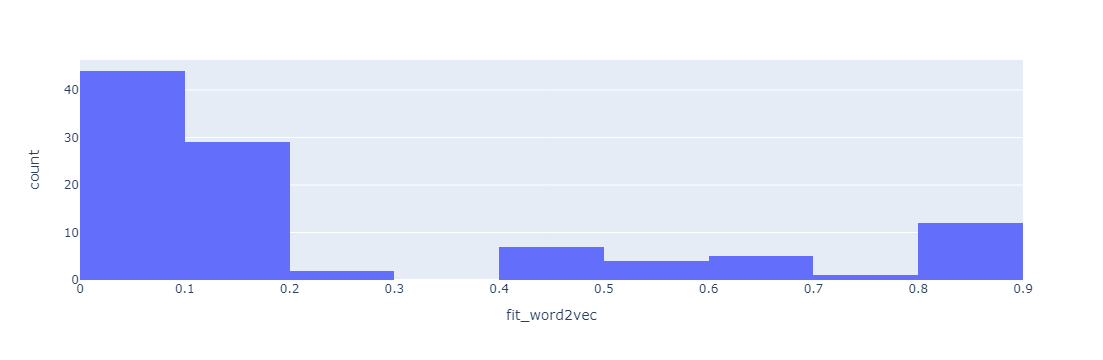

In [199]:
fig = px.histogram(df['fit_word2vec'], x="fit_word2vec")
fig

In [200]:
query = "seeking human resources"
cos_sim_w2v = get_w2v_query_similarity(document_word_embeddings, [query])
df['fit_word2vec'] = cos_sim_w2v


In [201]:
top_candidates(n = 50, by = 'fit_word2vec', ascending = False, min_con = 0)

,job_title,location,connection,fit_word2vec
id,,,,
99,seeking human resources position,"Las Vegas, Nevada Area",48,0.886226
30,seeking human resources opportunities,"Chicago, Illinois",390,0.839381
28,seeking human resources opportunities,"Chicago, Illinois",390,0.839381
3,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.663209
58,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.663209
17,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.663209
33,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.663209
46,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.663209
97,aspiring human resources professional,"Kokomo, Indiana Area",71,0.663209


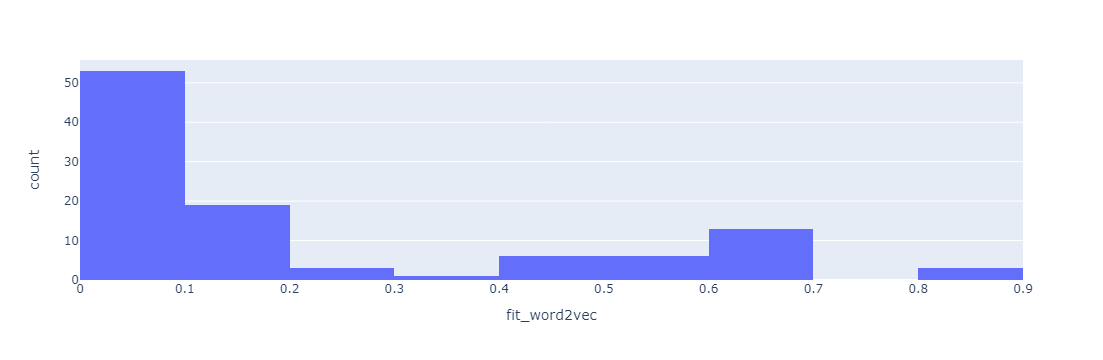

In [202]:
fig = px.histogram(df['fit_word2vec'], x="fit_word2vec")
fig

Also in this case the results are not great, let's try with another model.

### BERT

Good practice for reproducibility

In [203]:
# Set a random seed
random_seed = 42
random.seed(random_seed)
 
# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

Load pretrained model

In [204]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Defining query pre processing as done in data

In [205]:
def pre_processing(query):
        words = [lemmatizer.lemmatize(word) for word in word_tokenize(query)]
        words=[word.lower() for word in words if word.isalpha()]
        filtered_words = [word for word in words if word.lower() not in stopwords.words('english')]
        query = ' '.join(TreebankWordDetokenizer().detokenize(filtered_words).lower().split())
        query = query.replace('bauer','').lstrip()
        query = query.replace('svp','senior vice president').lstrip()
        query = query.replace('csr','corporate social responsability').lstrip()
        query = query.replace('chro','chief human resources officer').lstrip()
        query = query.replace('gphr','global professional in human resources').lstrip()
        query = query.replace('sphr','senior professional in human resources').lstrip()
        query = query.replace('mes','manufacturing execution system').lstrip()
        query = query.replace('hris','human resources information system').lstrip()
        query = query.replace('hr','human resource').lstrip()
        return query

Method to compute similarity scores

In [206]:
def compute_similarity_score(sentence, query_sentence):
    
    # Tokenize and encode sentence using batch_encode_plus
    # The function returns a dictionary containing the token IDs and attention masks
    encoding = tokenizer.encode_plus(
        sentence,                    # List of input texts
        return_tensors='pt',      # Return PyTorch tensors
        return_attention_mask=True,
        add_special_tokens=True    # Add special tokens CLS and SEP
    )
 
    input_ids = encoding['input_ids']  # Token IDs
    attention_mask = encoding['attention_mask']  # Attention mask
    # Generate embeddings using BERT model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        word_embeddings = outputs.last_hidden_state  # This contains the embeddings
    # Compute the average of word embeddings to get the sentence embedding
    sentence_embedding = word_embeddings.mean(dim=1)  # Average pooling along the sequence length dimension
    # Tokenize and encode the query sentence
    query_encoding = tokenizer.encode_plus(
        query_sentence,
        return_tensors='pt',
        return_attention_mask=True,
        add_special_tokens=True
    )
    query_input_ids = query_encoding['input_ids']
    query_attention_mask = query_encoding['attention_mask']
 
    # Generate embeddings for the query sentence
    with torch.no_grad():
        query_outputs = model(query_input_ids, attention_mask=query_attention_mask)
        query_sentence_embedding = query_outputs.last_hidden_state.mean(dim=1)
 
    # Compute cosine similarity between the original sentence embedding and the query sentence embedding
    similarity_score = cosine_similarity(sentence_embedding, query_sentence_embedding)
 
    # Return similarity score
    return similarity_score[0][0]

In [207]:
def compute_fit(query):
    for ind, row in df.iterrows():
        df.loc[ind,'fit_bert'] = round(predict_similarity([row['job_title'],query]),2)

Compute scores for each job_title and save result

In [208]:
query = "Aspiring human resources"
for ind, row in df.iterrows():
    df.loc[ind,'fit_bert'] = compute_similarity_score(row['job_title'],query)

In [209]:
top_candidates(n = 50, by = 'fit_bert', ascending = False, min_con = 0)

,job_title,location,connection,fit_word2vec,fit_bert
id,,,,,
24,aspiring human resources specialist,Greater New York City Area,1,0.645122,0.905480
60,aspiring human resources specialist,Greater New York City Area,1,0.645122,0.905480
6,aspiring human resources specialist,Greater New York City Area,1,0.645122,0.905480
36,aspiring human resources specialist,Greater New York City Area,1,0.645122,0.905480
49,aspiring human resources specialist,Greater New York City Area,1,0.645122,0.905480
97,aspiring human resources professional,"Kokomo, Indiana Area",71,0.663209,0.902632
17,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.663209,0.902632
21,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.663209,0.902632
46,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.663209,0.902632


In [210]:
top_candidates(n = 60, by = 'fit_bert', ascending = True, min_con = 0)

,job_title,location,connection,fit_word2vec,fit_bert
id,,,,,
35,advisory board member celal bayar university,"İzmir, Türkiye",500,0.075786,0.442163
23,advisory board member celal bayar university,"İzmir, Türkiye",500,0.075786,0.442163
5,advisory board member celal bayar university,"İzmir, Türkiye",500,0.075786,0.442163
48,advisory board member celal bayar university,"İzmir, Türkiye",500,0.075786,0.442163
95,student westfield state university,"Bridgewater, Massachusetts",57,0.072322,0.511733
90,undergraduate research assistant styczynski lab,Greater Atlanta Area,155,0.101950,0.512272
91,lead official western illinois university,Greater Chicago Area,39,0.048381,0.528180
93,admissions representative community medical ce...,"Long Beach, California",9,0.078601,0.536840
11,student chapman university,"Lake Forest, California",2,0.070109,0.568805


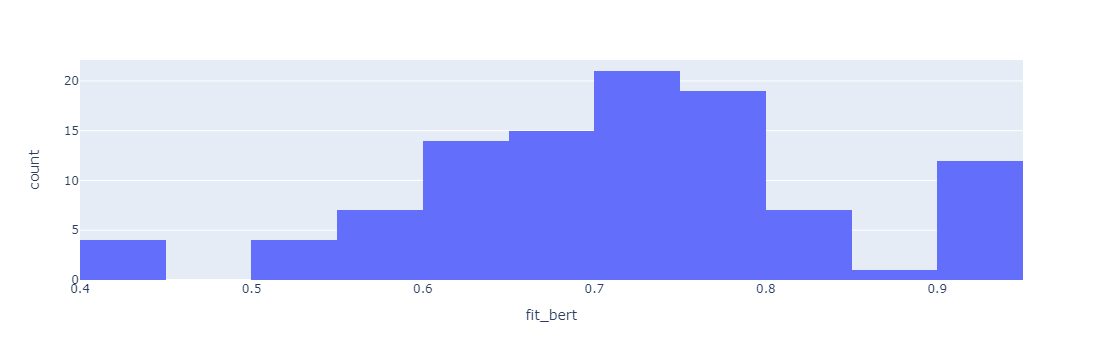

In [211]:
fig = px.histogram(df['fit_bert'], x="fit_bert")
fig

BERT pre-trained doesn't work with short sentences so in an a google colab notebook I pre-trained BERT for better cosine similiraties on sentences.

In [212]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [213]:
class BertForSTS(torch.nn.Module):

    def __init__(self):
        super(BertForSTS, self).__init__()
        self.bert = models.Transformer('bert-base-uncased', max_seq_length=128)
        self.pooling_layer = models.Pooling(self.bert.get_word_embedding_dimension())
        self.sts_bert = SentenceTransformer(modules=[self.bert, self.pooling_layer])

    def forward(self, input_data):
        output = self.sts_bert(input_data)['sentence_embedding']
        return output

In [214]:
PATH = 'bert-sts.pt'
model = BertForSTS()
model.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
model.eval()

BertForSTS(
  (bert): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (pooling_layer): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (sts_bert): SentenceTransformer(
    (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
    (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  )
)

In [215]:
def predict_similarity(sentence_pair):
  test_input = tokenizer(sentence_pair, padding='max_length', max_length = 128, truncation=True, return_tensors="pt").to(device)
  test_input['input_ids'] = test_input['input_ids']
  test_input['attention_mask'] = test_input['attention_mask']
  del test_input['token_type_ids']
  output = model(test_input)
  sim = torch.nn.functional.cosine_similarity(output[0], output[1], dim=0).item()
  return sim

In [216]:
query = "Aspiring human resources"
for ind, row in df.iterrows():
    df.loc[ind,'fit_bert'] = round(predict_similarity([row['job_title'],query]),2)

In [217]:
top_candidates(n = 50, by = 'fit_bert', ascending = False, min_con = 0)

,job_title,location,connection,fit_word2vec,fit_bert
id,,,,,
36,aspiring human resources specialist,Greater New York City Area,1,0.645122,0.84
24,aspiring human resources specialist,Greater New York City Area,1,0.645122,0.84
6,aspiring human resources specialist,Greater New York City Area,1,0.645122,0.84
60,aspiring human resources specialist,Greater New York City Area,1,0.645122,0.84
49,aspiring human resources specialist,Greater New York City Area,1,0.645122,0.84
58,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.663209,0.80
17,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.663209,0.80
33,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.663209,0.80
97,aspiring human resources professional,"Kokomo, Indiana Area",71,0.663209,0.80


In [218]:
top_candidates(n = 60, by = 'fit_bert', ascending = True, min_con = 0)

,job_title,location,connection,fit_word2vec,fit_bert
id,,,,,
87,bachelor science biology victoria university w...,"Baltimore, Maryland",40,0.115211,0.09
95,student westfield state university,"Bridgewater, Massachusetts",57,0.072322,0.13
91,lead official western illinois university,Greater Chicago Area,39,0.048381,0.15
90,undergraduate research assistant styczynski lab,Greater Atlanta Area,155,0.101950,0.16
93,admissions representative community medical ce...,"Long Beach, California",9,0.078601,0.16
41,student chapman university,"Lake Forest, California",2,0.070109,0.18
63,student chapman university,"Lake Forest, California",2,0.070109,0.18
85,rrp brand portfolio executive jti japan tobacc...,Greater Philadelphia Area,500,0.040384,0.18
54,student chapman university,"Lake Forest, California",2,0.070109,0.18


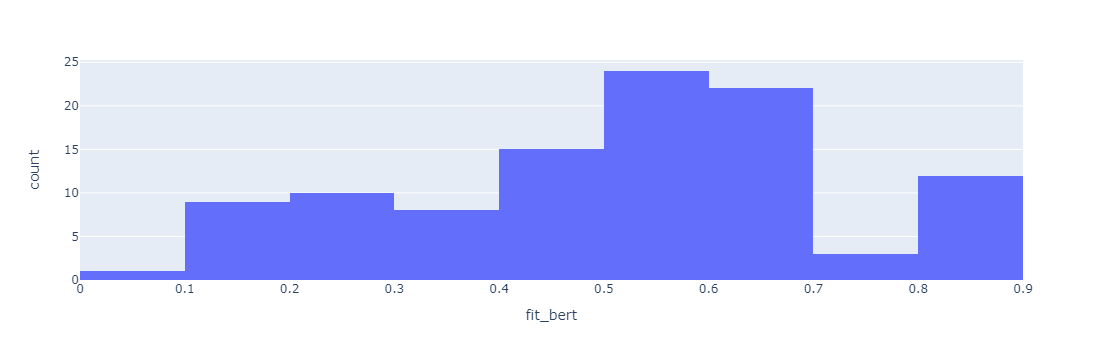

In [219]:
fig = px.histogram(df['fit_bert'], x="fit_bert")
fig

In [220]:
query = "seeking human resources"
for ind, row in df.iterrows():
    df.loc[ind,'fit_bert'] = round(predict_similarity([row['job_title'],query]),2)

In [221]:
top_candidates(n = 50, by = 'fit_bert', ascending = False, min_con = 0)

,job_title,location,connection,fit_word2vec,fit_bert
id,,,,,
30,seeking human resources opportunities,"Chicago, Illinois",390,0.839381,0.86
28,seeking human resources opportunities,"Chicago, Illinois",390,0.839381,0.86
99,seeking human resources position,"Las Vegas, Nevada Area",48,0.886226,0.82
53,seeking human resources human resources inform...,Greater Philadelphia Area,500,0.553227,0.69
40,seeking human resources human resources inform...,Greater Philadelphia Area,500,0.553227,0.69
62,seeking human resources human resources inform...,Greater Philadelphia Area,500,0.553227,0.69
10,seeking human resources human resources inform...,Greater Philadelphia Area,500,0.553227,0.69
74,human resources professional,Greater Boston Area,16,0.133104,0.65
94,seeking human resources opportunities open tra...,Amerika Birleşik Devletleri,415,0.639099,0.62


In [222]:
top_candidates(n = 50, by = 'fit_bert', ascending = True, min_con = 0)

,job_title,location,connection,fit_word2vec,fit_bert
id,,,,,
87,bachelor science biology victoria university w...,"Baltimore, Maryland",40,0.115211,0.08
85,rrp brand portfolio executive jti japan tobacc...,Greater Philadelphia Area,500,0.040384,0.12
32,native english teacher epik english program korea,Kanada,500,0.050053,0.13
16,native english teacher epik english program korea,Kanada,500,0.050053,0.13
20,native english teacher epik english program korea,Kanada,500,0.050053,0.13
45,native english teacher epik english program korea,Kanada,500,0.050053,0.13
2,native english teacher epik english program korea,Kanada,500,0.050053,0.13
90,undergraduate research assistant styczynski lab,Greater Atlanta Area,155,0.101950,0.14
48,advisory board member celal bayar university,"İzmir, Türkiye",500,0.075786,0.15


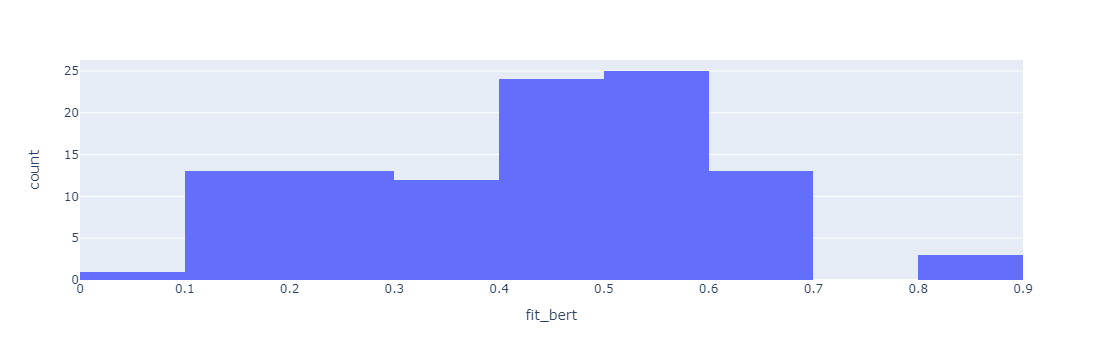

In [223]:
fig = px.histogram(df['fit_bert'], x="fit_bert")
fig

The pre-trained BERT seems to be more robust so we choose this model. Assign this as fit function

In [224]:
df = df.rename({'fit_bert': 'fit'}, axis=1)
df = df.drop('fit_word2vec', axis=1)

In [225]:
top_candidates(n = 50, by = 'fit', ascending = False, min_con = 0)

,job_title,location,connection,fit
id,,,,
30,seeking human resources opportunities,"Chicago, Illinois",390,0.86
28,seeking human resources opportunities,"Chicago, Illinois",390,0.86
99,seeking human resources position,"Las Vegas, Nevada Area",48,0.82
53,seeking human resources human resources inform...,Greater Philadelphia Area,500,0.69
40,seeking human resources human resources inform...,Greater Philadelphia Area,500,0.69
62,seeking human resources human resources inform...,Greater Philadelphia Area,500,0.69
10,seeking human resources human resources inform...,Greater Philadelphia Area,500,0.69
74,human resources professional,Greater Boston Area,16,0.65
94,seeking human resources opportunities open tra...,Amerika Birleşik Devletleri,415,0.62


In [226]:
def compute_fit(query):
    for ind, row in df.iterrows():
        df.loc[ind,'fit'] = round(predict_similarity([row['job_title'],query]),2)

### Manual starring

In [227]:
query = "Aspiring human resources"
compute_fit(query)

In [228]:
top_candidates(n = 50, by = 'fit', ascending = False, min_con = 0)

,job_title,location,connection,fit
id,,,,
36,aspiring human resources specialist,Greater New York City Area,1,0.84
24,aspiring human resources specialist,Greater New York City Area,1,0.84
6,aspiring human resources specialist,Greater New York City Area,1,0.84
60,aspiring human resources specialist,Greater New York City Area,1,0.84
49,aspiring human resources specialist,Greater New York City Area,1,0.84
58,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.80
17,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.80
33,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.80
97,aspiring human resources professional,"Kokomo, Indiana Area",71,0.80


Let's say we star the 17th called "seeking human resources position"	

In [229]:
def starring(query):
    compute_fit(query)

In [230]:
starring("seeking human resources position")

In [231]:
top_candidates(n = 50, by = 'fit', ascending = False, min_con = 0)

,job_title,location,connection,fit
id,,,,
99,seeking human resources position,"Las Vegas, Nevada Area",48,1.00
30,seeking human resources opportunities,"Chicago, Illinois",390,0.85
28,seeking human resources opportunities,"Chicago, Illinois",390,0.85
62,seeking human resources human resources inform...,Greater Philadelphia Area,500,0.75
40,seeking human resources human resources inform...,Greater Philadelphia Area,500,0.75
10,seeking human resources human resources inform...,Greater Philadelphia Area,500,0.75
53,seeking human resources human resources inform...,Greater Philadelphia Area,500,0.75
46,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.71
17,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,0.71


The manual re-ranking works as expected

### Bonus questions

Looking at the scores we can say that candidates with scores<=0.20 are not suitable and should not be there. Entries with scores>=0.70 are good candidates and should be stored for fututure positions. In order to avoid manual re-ranking bias, it should be prohibited to rerank candidates with scores <= 0.50 because they are likely to be not good.